# Human Fibroblast -> iPSC/hESC

Single-cell RNA-seq reveals novel regulators of human embryonic stem cell differentiation to definitive endoderm, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748

## Import libraries and set working directory

In [1]:
import os
import pickle
import torch
import random
import logging
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
logging.getLogger('matplotlib.font_manager').disabled = True
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
from sklearn.linear_model import TheilSenRegressor
import scipy
from dcor import distance_correlation
import warnings
warnings.filterwarnings('ignore')
import omicverse as ov
import sys
sys.path.append('../')

from CauTrigger.utils import set_seed
from CauTrigger.model import CauTrigger

BASE_DIR = '/your/working/directory'
case_path = os.path.join(BASE_DIR, 'CaseFibroblast2IPSC/')
data_path = os.path.join(case_path, 'data/')
output_path = os.path.join(case_path, 'output/')
os.makedirs(output_path, exist_ok=True)


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.8, Tutorials: https://omicverse.readthedocs.io/


In [2]:
Trrust = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()
Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)

In [3]:
expData = pd.read_csv(os.path.join(data_path, 'GSE75748_sc_cell_type_ec.csv.gz'), index_col=0).transpose()
adata = sc.AnnData(X=expData, dtype=np.float32)
adata.obs['cell_type'] = [index.split('_')[0] for index in adata.obs.index]
adata = adata[adata.obs['cell_type'].isin(['H1', 'HFF'])]
adata.obs['labels'] = adata.obs['cell_type'].map({'H1': 0, 'HFF': 1})
adata.obs['cell_type'] = adata.obs['cell_type'].map({'H1': 'ESC', 'HFF': 'Fibroblast'})
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [4]:
ctrl_mtx = pd.DataFrame(adata.X[adata.obs['labels'] == 0].copy().T, index=adata.var_names, columns=adata[adata.obs['labels'] == 0].obs_names)
treat_mtx = pd.DataFrame(adata.X[adata.obs['labels'] == 1].copy().T, index=adata.var_names, columns=adata[adata.obs['labels'] == 1].obs_names)
mtx = pd.concat([ctrl_mtx, treat_mtx], axis=1)
dds = ov.bulk.pyDEG(mtx)
treatment_groups = np.array(treat_mtx.columns)
control_groups = np.array(ctrl_mtx.columns)
result = dds.deg_analysis(treatment_groups, control_groups, method='ttest').sort_values(by='abs(log2FC)', ascending=False)
result1 = result[result.sig == 'sig']

In [5]:
outdegree = pd.DataFrame(np.unique(Trrust.iloc[:,0], return_counts=True)).T
DEGtrrust = Trrust[np.isin(Trrust.iloc[:,1], result1.index)]
outdegree_deg = pd.DataFrame(np.unique(DEGtrrust.iloc[:,0], return_counts=True)).T
outdegree_deg.index = outdegree_deg.iloc[:,0]
outdegree1 = outdegree[np.isin(outdegree.iloc[:,0], outdegree_deg.iloc[:,0])]
outdegree1.index = outdegree1.iloc[:,0]
deg_per = pd.DataFrame({'percent':outdegree_deg.iloc[:,1] / outdegree1.iloc[:,1]})
deg_per.index = outdegree_deg.iloc[:,0]
all_df = pd.concat([outdegree1, outdegree_deg, deg_per], axis=1)
all_df1 = all_df[all_df.iloc[:,1]>10]
all_df1 = all_df1[all_df1.iloc[:,3]>10]
all_df1 = all_df1.sort_values(by='percent', ascending=False)

         Falling back to preprocessing with `sc.pp.pca` and default params.


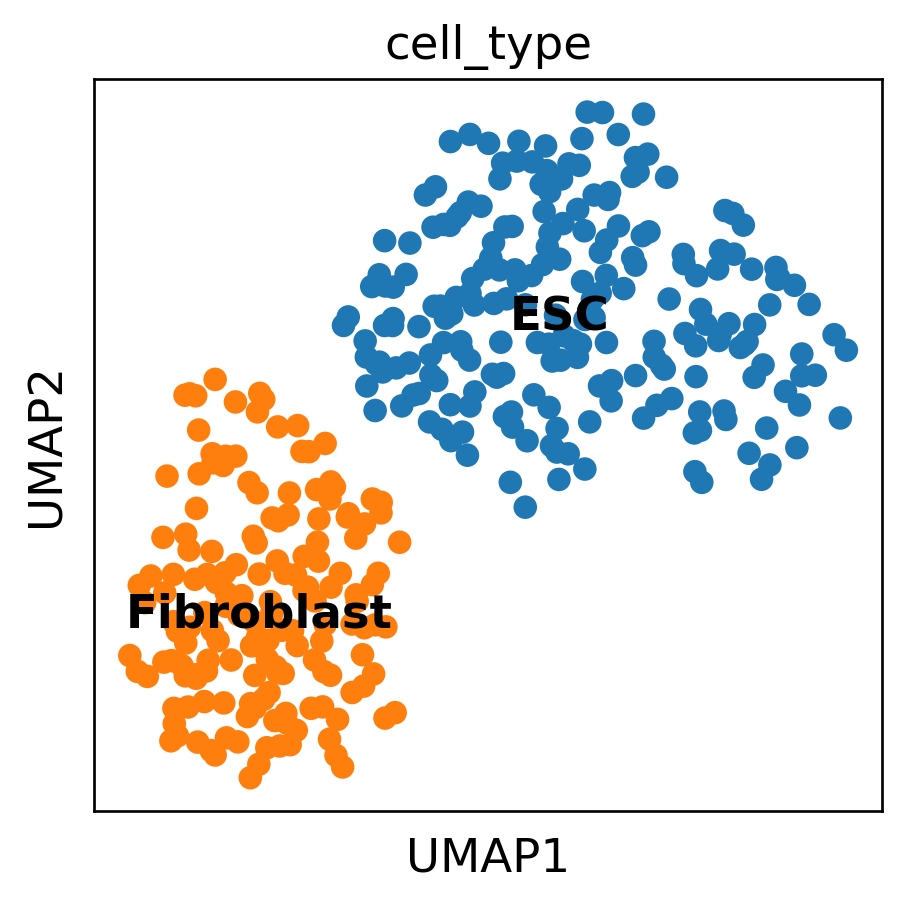

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=2.2, random_state=0)
sc.pl.umap(adata, color='cell_type', size=200, legend_loc='on data', show=False,palette=sns.color_palette())
plt.tight_layout()

## Train CauTrigger model

In [7]:
adata_ct = adata.copy()
adata_ct.obsm['X_down'] = adata_ct.X[:, adata_ct.var_names.isin(Trrust_nonTF)].copy()
adata_ct = adata_ct[:, adata_ct.var_names.isin(Trrust_TF)]

In [8]:
init_weight_df = pd.DataFrame({'weight':0.5}, index=adata_ct.var_names)
all_df2 = all_df1.copy()
all_df2['percent'] = 1
for i in all_df1.index:
    init_weight_df.loc[i,:] = all_df2.loc[i,'percent']

In [9]:
seed = 1
max_epochs = 200
set_seed(seed)
model = CauTrigger(
        adata_ct,
        n_causal=2,
        n_latent=10,
        n_hidden=256,
        n_layers_encoder=1,
        n_layers_decoder=1,
        n_layers_dpd=1,
        dropout_rate_encoder=0.5,
        dropout_rate_decoder=0.5,
        dropout_rate_dpd=0.5,
        use_batch_norm='none',
        use_batch_norm_dpd=True,
        decoder_linear=True,
        dpd_linear=False,
        init_weight=init_weight_df.weight,
        init_thresh=0.0,
        update_down_weight=False,
        attention=False,
        att_mean=False,
        direct_causal=False,
    )
weight_scheme = {'stage1': [0.1, 2.0, 2.0, 1, 0.2, 0.2, 0.0, 0.1, 0.1],
                         'stage2': [0.4, 1.0, 1.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.1],
                         'stage3': [0.8, 0.5, 0.5, 0.5, 0.0, 0.1, 2.0, 0.1, 0.1],
                         'stage4': [1, 0.2, 0.2, 0.5, 0.0, 0.0, 2.0, 2.0, 2.0]}
model.train(max_epochs=max_epochs, im_factor=1, weight_scheme=weight_scheme)
print(model.get_up_feature_weights(normalize=False, method="Model", sort_by_weight=True)[0])
print('SOX2:', list(model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].index).index('SOX2'),',',model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].loc['SOX2'])
print('POU5F1:', list(model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].index).index('POU5F1'),',',model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].loc['POU5F1'])
print('NANOG:', list(model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].index).index('NANOG'),',',model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].loc['NANOG'])
print('KLF4:', list(model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].index).index('KLF4'),',',model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].loc['KLF4'])
print('MYC:', list(model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].index).index('MYC'),',',model.get_up_feature_weights(normalize=True, method="Model", sort_by_weight=True)[0].loc['MYC'])

training: 100%|██████████| 200/200 [01:00<00:00,  3.33it/s]

          weight
PARP1   0.725250
KLF6    0.725099
FOS     0.724941
NFIC    0.724812
POU5F1  0.724789
...          ...
HNRNPR  0.613266
CNBP    0.613231
XRCC5   0.613193
APEX1   0.613087
ATRX    0.613068

[787 rows x 1 columns]
SOX2: 15 , weight    0.001459
Name: SOX2, dtype: float32
POU5F1: 4 , weight    0.00146
Name: POU5F1, dtype: float32
NANOG: 5 , weight    0.001459
Name: NANOG, dtype: float32
KLF4: 31 , weight    0.001458
Name: KLF4, dtype: float32
MYC: 56 , weight    0.001458
Name: MYC, dtype: float32


In [518]:
TF_all_rank_df = pd.DataFrame(model.get_up_feature_weights(normalize=False, method="Model", sort_by_weight=True)[0])
TF_all_rank_df.to_csv(os.path.join(output_path, 'TF_all_rank_df.csv'))
DEGtrrust.to_csv(os.path.join(output_path, 'DEGtrrust.csv'))

In [519]:
grad_df_full_logit = pd.DataFrame(model.get_up_feature_weights(normalize=True, method='Grad', grad_source='logit', sort_by_weight=False)[1], columns=adata_ct.var.copy().index)
grad_df_full_logit['labels'] = np.array(adata_ct.obs['labels'])
grad_df_full_logit = grad_df_full_logit.groupby('labels').mean()

In [520]:
grad_df_full_logit_KO_binary = grad_df_full_logit.applymap(lambda x: 'Up' if x > 0 else ('Down' if x < 0 else x))
grad_df_full_logit_Activation_binary = grad_df_full_logit.applymap(lambda x: 'Down' if x > 0 else ('Up' if x < 0 else x))

In [521]:
grad_df_full_logit_KO_binary.loc[1,TF_all_rank_df.index].to_csv(output_path+'grad_df_full_logit_KO_binary.csv')

## GI analysis

In [522]:
def calculate_GIs(first_expr, second_expr, double_expr):
    from sklearn.linear_model import TheilSenRegressor
    from dcor import distance_correlation
    singles_expr = np.array([first_expr, second_expr]).T
    first_expr = first_expr.T
    second_expr = second_expr.T
    double_expr = double_expr.T
    results = {}
    results['ts'] = TheilSenRegressor(fit_intercept=False,
                                      max_subpopulation=1e5,
                                      max_iter=1000,
                                      random_state=1000)
    X = singles_expr
    y = double_expr
    results['ts'].fit(X, y.ravel())
    Zts = results['ts'].predict(X)
    results['c1'] = results['ts'].coef_[0]
    results['c2'] = results['ts'].coef_[1]
    results['mag'] = np.sqrt((results['c1'] ** 2 + results['c2'] ** 2))
    results['dcor'] = distance_correlation(singles_expr, double_expr)
    results['dcor_singles'] = distance_correlation(first_expr, second_expr)
    results['dcor_first'] = distance_correlation(first_expr, double_expr)
    results['dcor_second'] = distance_correlation(second_expr, double_expr)
    results['corr_fit'] = np.corrcoef(Zts.flatten(), double_expr.flatten())[0, 1]
    results['dominance'] = np.abs(np.log10(results['c1'] / results['c2']))
    results['eq_contr'] = np.min([results['dcor_first'], results['dcor_second']]) / np.max(
        [results['dcor_first'], results['dcor_second']])
    return results

In [ ]:
genes = TF_all_rank_df[0:10].index
from itertools import combinations
genescombs = list(combinations(genes, 2))
synergy_score_down = pd.DataFrame({'MAG':0},index=['+'.join(i) for i in genescombs])
synergy_score_up = pd.DataFrame({'MAG':0},index=['+'.join(i) for i in genescombs])
adata_TF = adata[:, adata.var_names.isin(Trrust_TF)].copy()
adata_down = adata[:, adata.var_names.isin(Trrust_nonTF)].copy()
state_pair = ('ESC', 'Fibroblast')
state_obs = 'cell_type'
for id, pair in enumerate(genescombs):
    adata_pert = adata_TF.copy()
    adata_pert = adata_pert[adata_pert.obs[state_obs] == 'Fibroblast']
    adata_pert.X[:, adata_pert.var_names.get_loc(pair[0])] = 2 * adata_TF.X.max()
    model.eval()
    with torch.no_grad():
        model_output_pertA =model.module.forward(torch.Tensor(adata_pert.X).to('cuda:0'))
    adata_pert = adata_TF.copy()
    adata_pert = adata_pert[adata_pert.obs[state_obs] == 'Fibroblast']
    adata_pert.X[:, adata_pert.var_names.get_loc(pair[1])] = 2 * adata_TF.X.max()
    model.eval()
    with torch.no_grad():
        model_output_pertB = model.module.forward(torch.Tensor(adata_pert.X).to('cuda:0'))
    adata_pert = adata_TF.copy()
    adata_pert = adata_pert[adata_pert.obs[state_obs] == 'Fibroblast']
    adata_pert.X[:, adata_pert.var_names.get_loc(pair[0])] = 2 * adata_TF.X.max()
    adata_pert.X[:, adata_pert.var_names.get_loc(pair[1])] = 2 * adata_TF.X.max()
    model.eval()
    with torch.no_grad():
        model_output_pertAB = model.module.forward(torch.Tensor(adata_pert.X).to('cuda:0'))
    ctrl = np.squeeze(np.concatenate([adata_TF.X, adata_down.X], axis=1).mean(0))
    predA = np.squeeze(np.concatenate([model_output_pertA['x_up_rec1'].cpu().numpy(), model_output_pertA['x_down_rec_alpha'].cpu().numpy()], axis=1).mean(0))
    predB = np.squeeze(np.concatenate([model_output_pertB['x_up_rec1'].cpu().numpy(), model_output_pertB['x_down_rec_alpha'].cpu().numpy()], axis=1).mean(0))
    predAB = np.squeeze(np.concatenate([model_output_pertAB['x_up_rec1'].cpu().numpy(), model_output_pertAB['x_down_rec_alpha'].cpu().numpy()], axis=1).mean(0))
    results = calculate_GIs(predA - ctrl, predB - ctrl, predAB - ctrl)
    synergy_score_up.iloc[id, 0] = results['mag']

synergy_score_up.sort_values(by='MAG', ascending=False).to_csv(os.path.join(output_path, 'Synergy_score_up.csv'))

## Calculate the state transition onset(>=50%) perturbation fold

In [18]:
adata_TF = adata[:, adata.var_names.isin(Trrust_TF)].copy()
adata_down = adata[:, adata.var_names.isin(Trrust_nonTF)].copy()
state_pair = ('ESC', 'Fibroblast')
combo = ['PARP1', 'POU5F1', 'NANOG']
state_obs = 'cell_type'

In [209]:
def search_onset_fold(pert, increment=1):
    label = 0
    pertA = pert
    for fold in np.arange(2, 1000, increment):
        adata_pertA = adata_TF.copy()
        pert_cell_idx = np.where(adata_TF.obs[state_obs] == state_pair[1])[0]
        adata_pertA = adata_pertA[pert_cell_idx, :]
        adata_ctrl = adata_down.copy()
        adata_ctrl = adata_ctrl[np.where(adata_down.obs[state_obs] == state_pair[0])[0], :]
        adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = fold * adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)].max() / adata_pertA.X.max() * 8
        model.eval()
        with torch.no_grad():
            model_output_pertA = model.get_model_output(adata_pertA)
        predsA = (len(model_output_pertA['preds']) - model_output_pertA['preds'].sum()) / len(model_output_pertA['preds'])
        if predsA >= 0.5:
            label = 1
            print('found!')
            print(fold)
            print(predsA)
            break
    assert label == 1, "Resolution is not found. Please try bigger range or smaller step!."
    return fold

In [206]:
def search_onset_fold_combo(pert, rangeA, rangeB):
    label = 0
    pertA = pert[0]
    pertB = pert[1]
    from itertools import product
    range_A = range(rangeA[0], rangeA[1])
    range_B = range(rangeB[0], rangeB[1])
    combinations = [(a, b) for a, b in product(range_A, range_B)]
    for combo in combinations:
        adata_pertAB = adata_TF.copy()
        pert_cell_idx = np.where(adata_TF.obs[state_obs] == state_pair[1])[0]
        adata_pertAB = adata_pertAB[pert_cell_idx, :]
        adata_ctrl = adata_down.copy()
        adata_ctrl = adata_ctrl[np.where(adata_down.obs[state_obs] == state_pair[0])[0], :]
        max_ = adata_pertAB.X.max()
        adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertA)] = combo[0] * adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertA)].max() /max_ * 8
        adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertB)] = combo[1] * adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertB)].max() /max_ * 8
        model.eval()
        with torch.no_grad():
            model_output_pertAB = model.get_model_output(adata_pertAB)
        predsA = (len(model_output_pertAB['preds']) - model_output_pertAB['preds'].sum()) / len(model_output_pertAB['preds'])
        if predsA >= 0.5:
            label = 1
            print('found!')
            print(combo)
            print(predsA)
            break
    assert label == 1, "Resolution is not found. Please try bigger range or smaller step!."
    return combo

In [216]:
for pert in ['PARP1','POU5F1','NANOG']:
    search_onset_fold(pert)

Searching resolution...


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


found!
20
0.5471698113207547
Searching resolution...


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


found!
28
0.5660377358490566
Searching resolution...


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it 

found!
261
0.5031446540880503


In [214]:
foldAB = search_onset_fold_combo(pert= ['PARP1', 'POU5F1'], rangeA=[2,16], rangeB=[2,22])

Searching resolution...


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]

found!
(2, 19)
0.5283018867924528


In [215]:
foldAC = search_onset_fold_combo(pert= ['PARP1', 'NANOG'], rangeA=[2,16], rangeB=[2,209])

Searching resolution...


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


found!
(2, 23)
0.5283018867924528


## Plot vector field map

In [32]:
def plot_vector_field(adata,state_pair=None,KO_Gene=None,state_obs=None,embedding_name=None,method=None,
                      sampled_fraction=1, min_mass=0.008,scale=0.1, save_dir=None,smooth=0.8,n_grid=40,
                     draw_single=None,n_suggestion=12,show=True,dot_size=None,run_suggest_mass_thresholds=False,direction=None,n_neighbors=None,):
    from scipy import sparse
    from sklearn.neighbors import NearestNeighbors
    from velocyto.estimation import colDeltaCorpartial
    from scipy.stats import norm as normal
    import math

    def replace_with_CauTrigger(adata, corrcoef, state_pair=state_pair, state_obs=state_obs, method=method):
        corrcoef_ = corrcoef.copy()
        if method == 'prob':
            probs = adata.obs['probs'].copy()
            probs_pert = adata.obs['probs_pert'].copy()
        if method == 'logits':
            probs = adata.obs['logits'].copy()
            probs_pert = adata.obs['logits_pert'].copy()
        neigh_ixs = adata.uns['neigh_ixs'].copy()
        target_index = np.where((adata.obs[state_obs] == state_pair[0]) | (adata.obs[state_obs] == state_pair[1]))[0]
        nontarget_neighbor_index = np.setdiff1d(np.unique(neigh_ixs[target_index, :].flatten()), target_index)
        nonneighbor_index = np.setdiff1d(np.setdiff1d(np.arange(probs.shape[0]), target_index), nontarget_neighbor_index)
        for i in target_index:
            cols = np.setdiff1d(np.union1d(target_index, nontarget_neighbor_index), i)
            cor =  - abs(probs_pert[i] - probs[cols])
            corrcoef_[i, cols] = cor
        corrcoef_[np.union1d(nontarget_neighbor_index, nonneighbor_index), :] = 0
        return corrcoef_

    def estimate_transition_prob(adata, state_pair=state_pair,state_obs=state_obs, embedding_name=embedding_name, n_neighbors=None,
                                 sampled_fraction=sampled_fraction, sigma_corr=0.005, replace_prob=None,draw_single=None):
        sampling_probs = (0.5, 0.1)
        X = adata.layers["imputed_count"].transpose().copy()
        delta_X = adata.layers["delta_X"].transpose().copy()
        embedding = adata.obsm[embedding_name].copy()
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=4)
        nn.fit(embedding)
        embedding_knn = nn.kneighbors_graph(mode="connectivity")
        neigh_ixs = embedding_knn.indices.reshape((-1, n_neighbors + 1))
        p = np.linspace(sampling_probs[0], sampling_probs[1], neigh_ixs.shape[1])
        p = p / p.sum()
        sampling_ixs = np.stack([np.random.choice(neigh_ixs.shape[1],
                                                  size=(int(sampled_fraction * (n_neighbors + 1)),),
                                                  replace=False,
                                                  p=p) for i in range(neigh_ixs.shape[0])], 0)
        neigh_ixs = neigh_ixs[np.arange(neigh_ixs.shape[0])[:, None], sampling_ixs]
        nonzero = neigh_ixs.shape[0] * neigh_ixs.shape[1]
        embedding_knn = sparse.csr_matrix((np.ones(nonzero),
                                           neigh_ixs.ravel(),
                                           np.arange(0, nonzero + 1, neigh_ixs.shape[1])),
                                          shape=(neigh_ixs.shape[0],
                                                 neigh_ixs.shape[0]))
        adata.uns['neigh_ixs'] = neigh_ixs.copy()
        corrcoef = colDeltaCorpartial(X, delta_X, neigh_ixs)
        if replace_prob == 'prob':
            corrcoef = replace_with_CauTrigger(adata, corrcoef, state_pair=state_pair,state_obs=state_obs, method='prob')
        if replace_prob == 'logits':
            corrcoef = replace_with_CauTrigger(adata, corrcoef,state_pair=state_pair,state_obs=state_obs, method='logits')
        if np.any(np.isnan(corrcoef)):
            corrcoef[np.isnan(corrcoef)] = 1
        transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A
        transition_prob /= transition_prob.sum(1)[:, None]
        adata.obsm['embedding_knn'] = embedding_knn.copy()
        adata.obsp['transition_prob'] = transition_prob.copy()

    def calculate_embedding_shift(adata, embedding_name=embedding_name):
        transition_prob = adata.obsp['transition_prob'].copy()
        embedding = adata.obsm[embedding_name].copy()
        embedding_knn = adata.obsm['embedding_knn'].copy()
        unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
        with np.errstate(divide='ignore', invalid='ignore'):
            unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
            np.fill_diagonal(unitary_vectors[0, ...], 0)
            np.fill_diagonal(unitary_vectors[1, ...], 0)
        delta_embedding = (transition_prob * unitary_vectors).sum(2)
        delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
        delta_embedding = delta_embedding.T
        adata.obsm['delta_embedding'] = delta_embedding.copy()

    def calculate_p_mass(adata, embedding_name=embedding_name, smooth=smooth, n_grid=n_grid, n_neighbors=None,draw_single=None):
        steps = (n_grid, n_grid)
        embedding = adata.obsm[embedding_name].copy()
        if draw_single:
            adata_tmp = adata.copy()
            adata_tmp.obsm['delta_embedding'][adata_tmp.obs[state_obs] != draw_single] = 0
            delta_embedding = adata_tmp.obsm['delta_embedding'].copy()
        else:
            delta_embedding = adata.obsm['delta_embedding'].copy()
        grs = []
        for dim_i in range(embedding.shape[1]):
            m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])    
            m = m - 0.025 * np.abs(M - m)
            M = M + 0.025 * np.abs(M - m)
            gr = np.linspace(m, M, steps[dim_i])
            grs.append(gr)
        meshes_tuple = np.meshgrid(*grs)
        gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(embedding)
        dists, neighs = nn.kneighbors(gridpoints_coordinates)
        std = np.mean([(g[1] - g[0]) for g in grs])
        gaussian_w = normal.pdf(loc=0, scale=smooth * std, x=dists)
        total_p_mass = gaussian_w.sum(1)
        UZ = (delta_embedding[neighs] * gaussian_w[:, :, None]).sum(1) / np.maximum(1, total_p_mass)[:,None]
        magnitude = np.linalg.norm(UZ, axis=1)
        flow_embedding = embedding
        flow_grid = gridpoints_coordinates
        flow = UZ
        flow_norm = UZ / np.percentile(magnitude, 99.5)
        flow_norm_magnitude = np.linalg.norm(flow_norm, axis=1)
        adata.uns['total_p_mass'] = total_p_mass.copy()
        adata.uns['flow_grid'] = flow_grid.copy()
        adata.uns['flow'] = flow.copy()

    def suggest_mass_thresholds(adata, embedding_name=embedding_name, n_suggestion=n_suggestion,save_dir=save_dir, s=1, n_col=4):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        min_ = total_p_mass.min()
        max_ = total_p_mass.max()
        suggestions = np.linspace(min_, max_ / 2, n_suggestion)
        n_rows = math.ceil(n_suggestion / n_col)
        fig, ax = plt.subplots(n_rows, n_col, figsize=[5 * n_col, 5 * n_rows])
        if n_rows == 1:
            ax = ax.reshape(1, -1)
        row = 0
        col = 0
        for i in range(n_suggestion):
            ax_ = ax[row, col]
            col += 1
            if col == n_col:
                col = 0
                row += 1
            idx = total_p_mass > suggestions[i]
            ax_.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=s)
            ax_.scatter(flow_grid[idx, 0],
                        flow_grid[idx, 1],
                        c="black", s=s)
            ax_.set_title(f"min_mass: {suggestions[i]: .2g}")
            ax_.axis("off")
        plt.tight_layout()
        plt.savefig(f"{save_dir}/suggest_mass_thresholds.png", bbox_inches='tight')
        plt.show()

    def calculate_mass_filter(adata, embedding_name=embedding_name, min_mass=min_mass, plot=False):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        mass_filter = (total_p_mass < min_mass)
        adata.uns['mass_filter'] = mass_filter.copy()
        if plot:
            fig, ax = plt.subplots(figsize=[5, 5])
            ax.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=10)
            ax.scatter(flow_grid[~mass_filter, 0],
                       flow_grid[~mass_filter, 1],
                       c="black", s=0.5)
            ax.set_title("Grid points selected")
            ax.axis("off")
            plt.show()

    def plot_flow(adata, state_obs=state_obs, embedding_name=embedding_name, dot_size=dot_size, scale=scale, KO_Gene=KO_Gene, save_dir=save_dir, show=show,direction=direction):
        fig, ax = plt.subplots()
        sc.pl.embedding(adata, basis=embedding_name, color=state_obs, ax=ax, show=False,size=dot_size, palette=sns.color_palette())
        ax.set_title("")
        if ax.get_legend() is not None:
            ax.get_legend().set_visible(False)
        mass_filter = adata.uns['mass_filter'].copy()
        gridpoints_coordinates = adata.uns['flow_grid'].copy()
        flow = adata.uns['flow'].copy()
        ax.quiver(gridpoints_coordinates[~mass_filter, 0],
                           gridpoints_coordinates[~mass_filter, 1],
                           flow[~mass_filter, 0],
                           flow[~mass_filter, 1],
                           scale=scale)
        ax.axis("off")
        if direction == 'Activation':
            ax.set_title(f"{' and '.join(KO_Gene)} {direction}")
        elif direction =='both':
            ax.set_title(f"{KO_Gene[0]} Activation and {KO_Gene[1]} Knock Out")
        else:
            ax.set_title(f"{' and '.join(KO_Gene)} Knock Out")
        plt.tight_layout()
        if save_dir:
            if direction == 'Activation':
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} {direction}.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} {direction}.pdf", bbox_inches='tight', backend='Cairo')
            elif direction =='both':
                plt.savefig(f"{save_dir}/{KO_Gene[0]} Activation and {KO_Gene[1]} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{KO_Gene[0]} Activation and {KO_Gene[1]} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
            else:
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(KO_Gene)} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
        if show:
            plt.show()

    estimate_transition_prob(adata,state_pair=state_pair,state_obs=state_obs,embedding_name=embedding_name, replace_prob=method, n_neighbors=n_neighbors, sampled_fraction=1)
    calculate_embedding_shift(adata,embedding_name=embedding_name)
    calculate_p_mass(adata,embedding_name=embedding_name,draw_single=draw_single,n_neighbors=n_neighbors)
    if run_suggest_mass_thresholds:
        suggest_mass_thresholds(adata, embedding_name=embedding_name,n_suggestion=n_suggestion)
        return adata
    calculate_mass_filter(adata,embedding_name=embedding_name, min_mass=min_mass, plot=False)
    plot_flow(adata,state_obs=state_obs, embedding_name=embedding_name,dot_size=dot_size, scale=scale,show=show,direction=direction)
    return adata

In [175]:
def pert_plot_up(adata_TF, adata_down, model, state_pair, KO_Gene, state_obs,run_suggest_mass_thresholds,fold=2,dot_size=None, method=None, scale=0.1, min_mass=0.008,save_dir=None,draw_single=None,embedding_name='X_tsne',n_neighbors=None,n_grid=40):
    model.eval()
    with torch.no_grad():
        model_output = model.get_model_output(adata_TF)
    adata_pert = adata_TF.copy()
    pert_cell_idx = np.where((adata_TF.obs[state_obs] == state_pair[0]) | (adata_TF.obs[state_obs] == state_pair[1]))[0]
    for ind, gene in enumerate(KO_Gene):
        adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)] = adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)].max() * fold[ind]
    model.eval()
    with torch.no_grad():
        model_output_pert = model.get_model_output(adata_pert)
    adata_all = sc.concat([adata_TF, adata_down],axis=1)
    adata_all.obs = adata_TF.obs.copy()
    adata_all.uns = adata_TF.uns.copy()
    adata_all.obsm = adata_TF.obsm.copy()
    adata_all.obsp = adata_TF.obsp.copy()
    adata_all.obs['probs'] = model_output['probs'].copy()
    adata_all.obs['logits'] = model_output['logits'].copy()
    adata_all.obs['probs_pert'] = model_output_pert['probs'].copy()
    adata_all.obs['logits_pert'] = model_output_pert['logits'].copy()
    adata_all.layers["imputed_count"] = np.float64(np.exp(adata_all.X.copy()))
    adata_all.layers["simulated_count"] = np.float64(np.exp(np.concatenate([model_output_pert['x_up_rec1'].copy(), model_output_pert['x_down_rec_alpha'].copy()],axis=1)))
    adata_all.layers["delta_X"] = adata_all.layers["simulated_count"].copy() - adata_all.layers["imputed_count"].copy()
    paul_for_co = adata_down.copy()
    paul_for_co.layers['pert_X'] = model_output_pert['x_down_rec_alpha'].copy()
    paul_for_co.obs['probs'] = model_output['probs'].copy()
    paul_for_co.obs['logits'] = model_output['logits'].copy()
    paul_for_co.obs['probs_pert'] = model_output_pert['probs'].copy()
    paul_for_co.obs['logits_pert'] = model_output_pert['logits'].copy()
    paul_for_co.layers["imputed_count"] = np.float64(paul_for_co.X.copy())
    paul_for_co.layers["simulated_count"] = np.float64(paul_for_co.layers['pert_X'].copy())
    paul_for_co.layers["delta_X"] = paul_for_co.layers["simulated_count"].copy() - paul_for_co.layers["imputed_count"].copy()
    non_pert_cell_idx = np.where(~((adata_TF.obs[state_obs] == state_pair[0]) | (adata_TF.obs[state_obs] == state_pair[1])))[0]
    paul_for_co.layers["delta_X"][non_pert_cell_idx, :] = 0
    ax = plot_vector_field(adata_all, state_pair=state_pair, state_obs=state_obs, embedding_name=embedding_name,direction='Activation',
                                  method=method, KO_Gene=KO_Gene, scale=scale,min_mass=min_mass, save_dir=save_dir,draw_single=draw_single,dot_size=dot_size,run_suggest_mass_thresholds=run_suggest_mass_thresholds,n_neighbors=n_neighbors,n_grid=n_grid)

In [26]:
adata_TF = adata[:, adata.var_names.isin(Trrust_TF)].copy()
adata_down = adata[:, adata.var_names.isin(Trrust_nonTF)].copy()
state_pair = ('ESC', 'Fibroblast')
state_obs = 'cell_type'
dot_size = 200

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


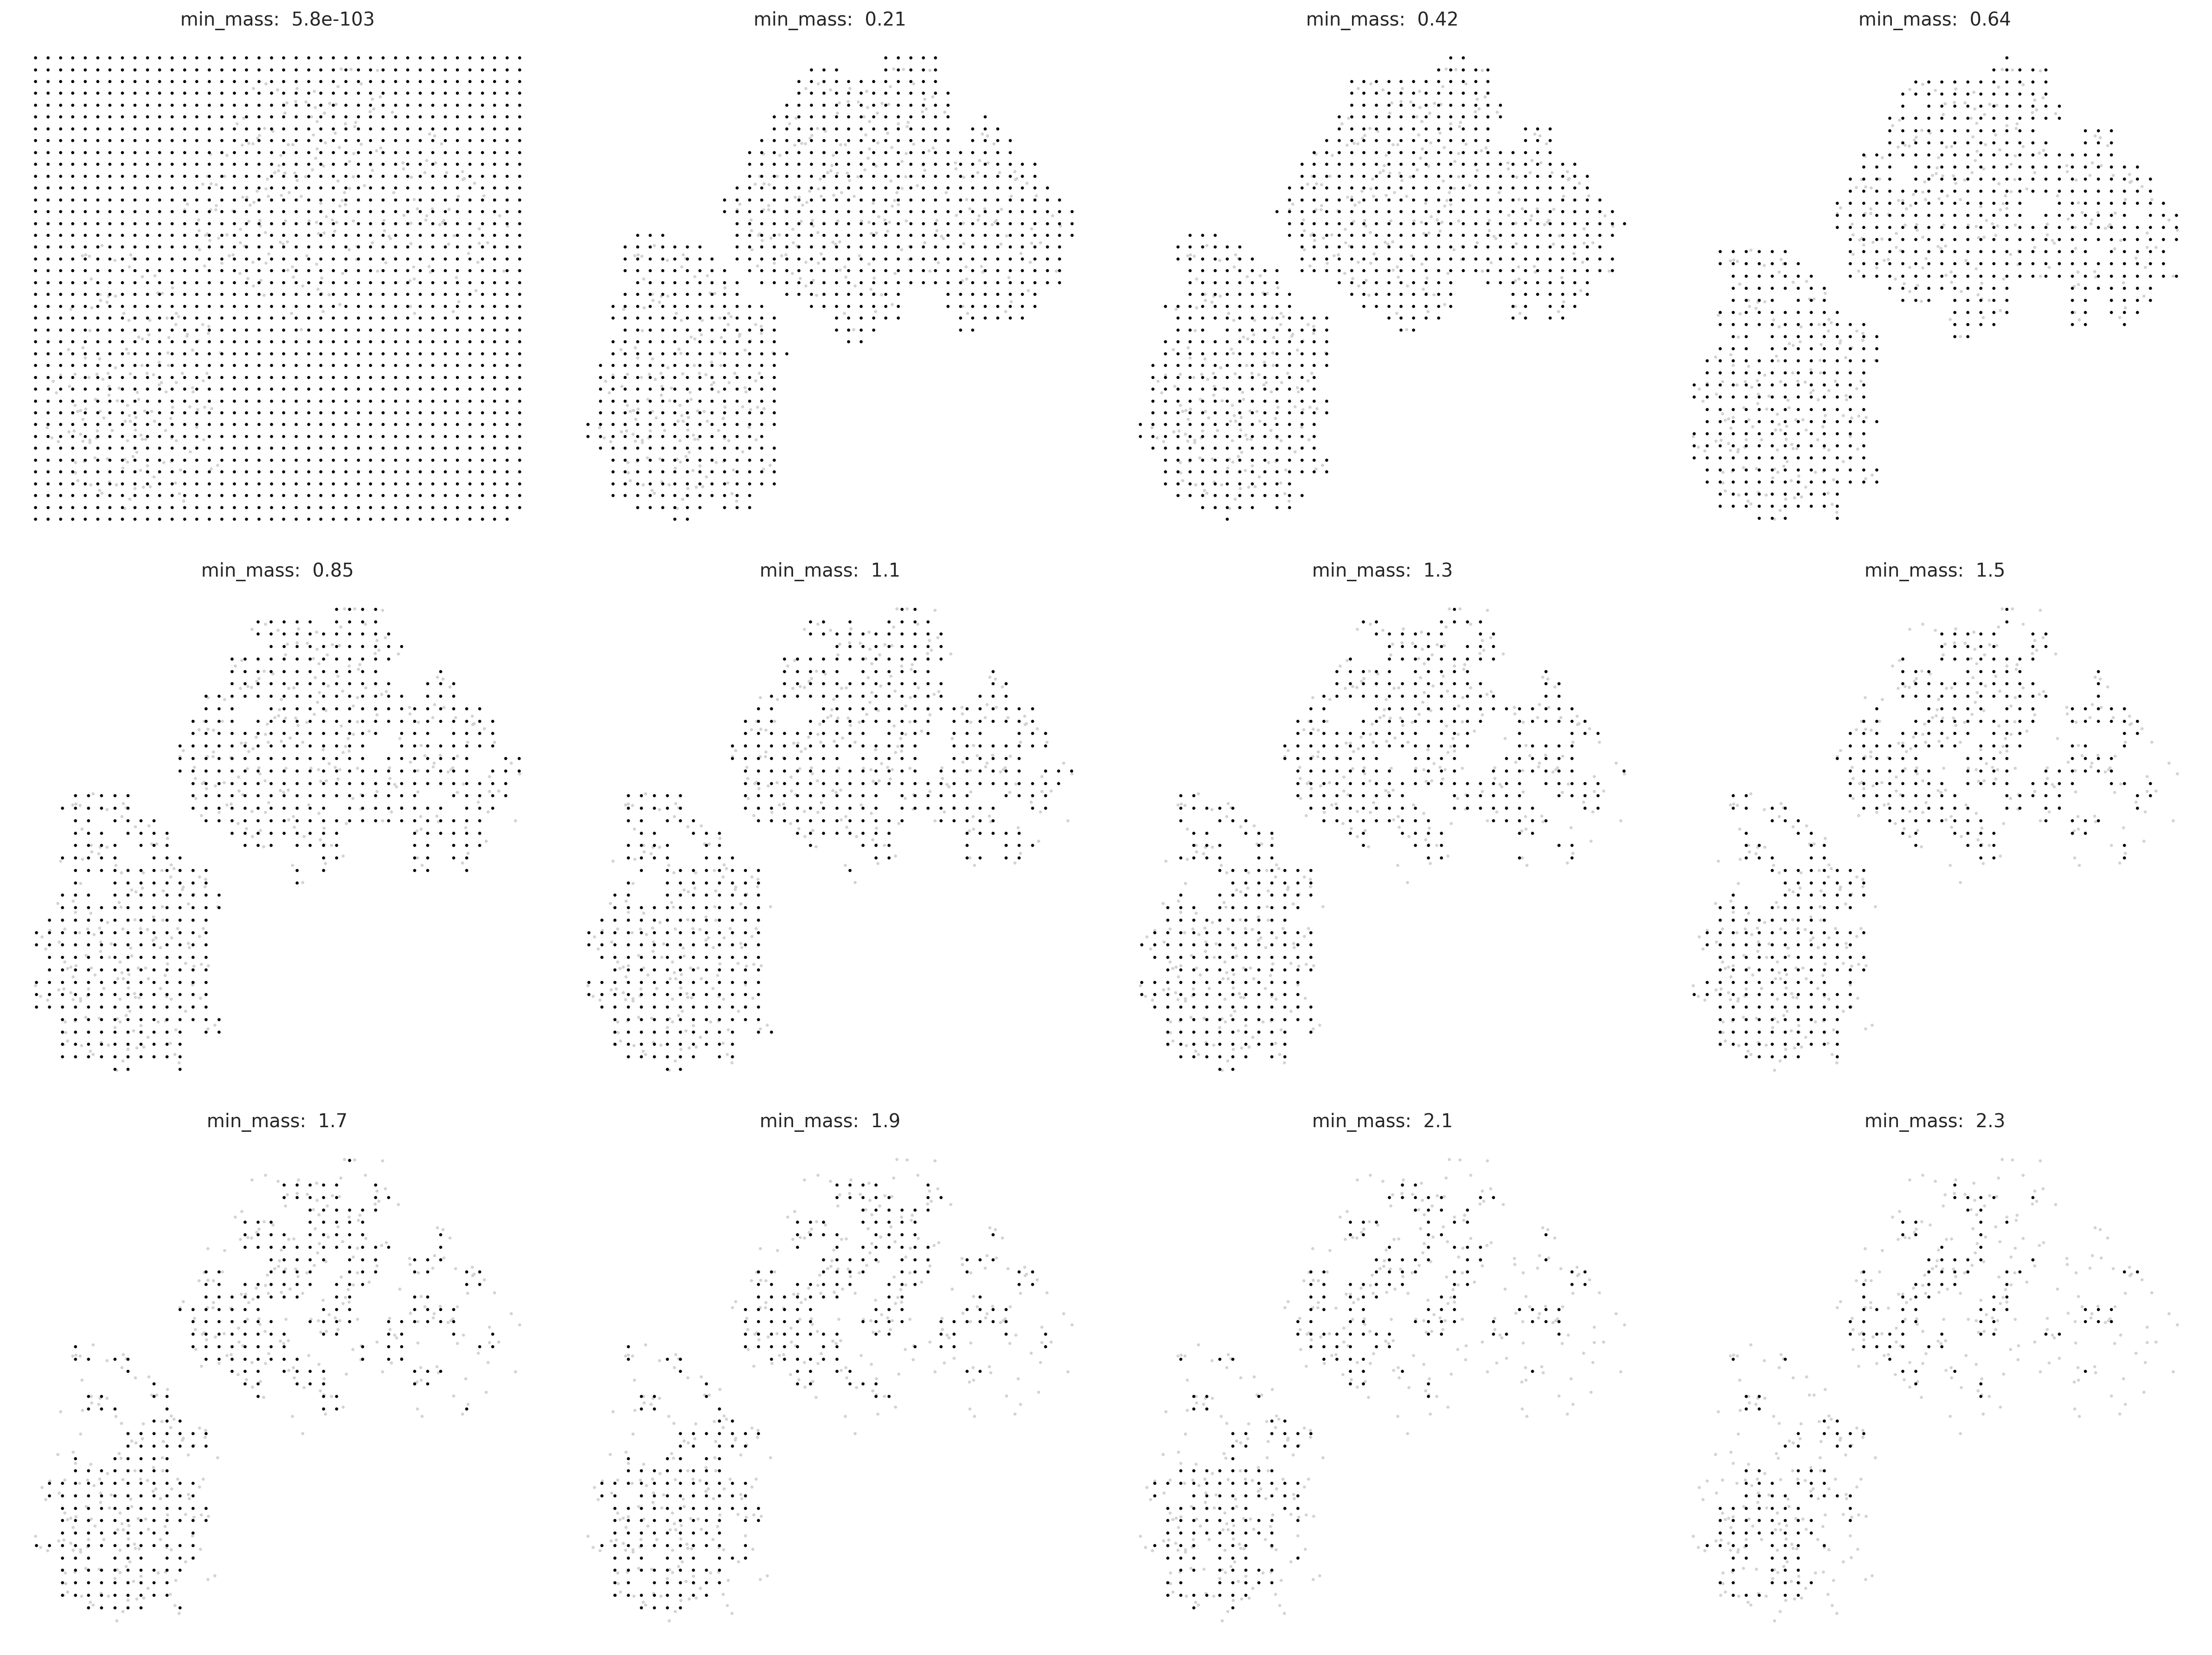

In [562]:
pert_plot_down(adata_TF, adata_down, model, state_pair=state_pair, KO_Gene=['SOX2'], state_obs=state_obs,run_suggest_mass_thresholds=True,dot_size=dot_size, method=None, scale=0.1, min_mass=0.008,save_dir=output_path,draw_single=None,embedding_name='X_umap')

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2b66476d3be0>
Traceback (most recent call last):
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_co

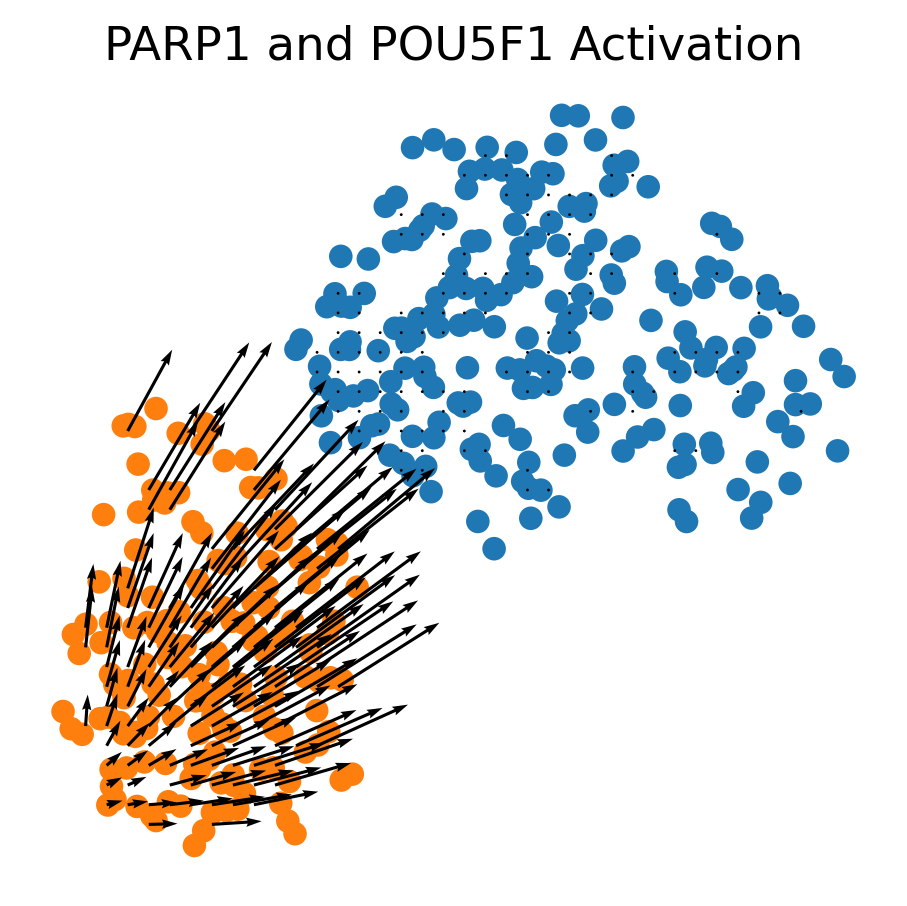

In [183]:
pert_plot_up(adata_TF, adata_down, model, state_pair=('ESC', 'Fibroblast'), KO_Gene=['PARP1','POU5F1'], state_obs=state_obs,run_suggest_mass_thresholds=False,fold=[40,50],dot_size=dot_size, method=None, scale=8, min_mass=2,save_dir=output_path,draw_single='Fibroblast',embedding_name='X_umap',n_neighbors=200)

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2b66477f5630>
Traceback (most recent call last):
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_co

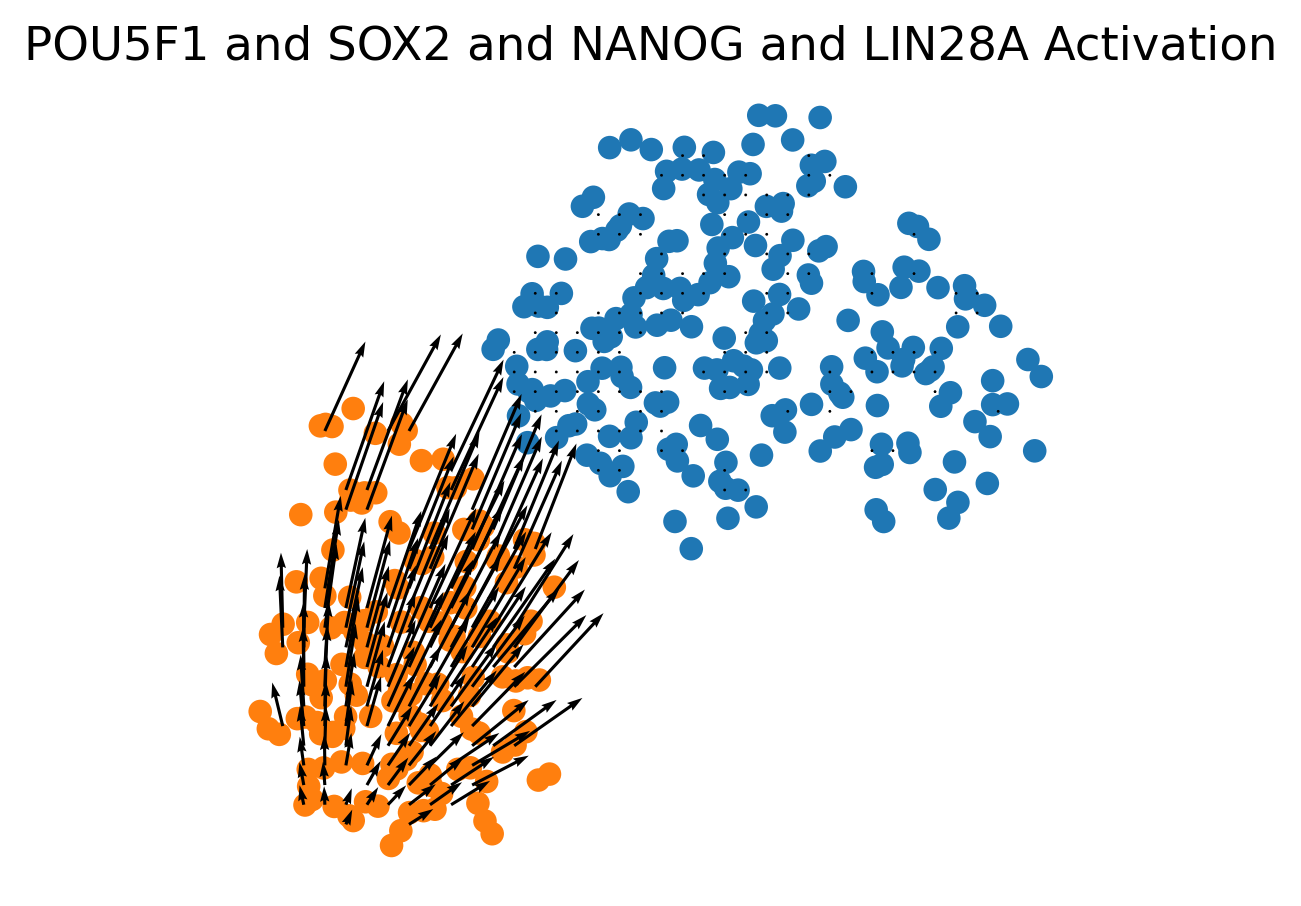

In [185]:
pert_plot_up(adata_TF, adata_down, model, state_pair=('ESC', 'Fibroblast'), KO_Gene=['POU5F1','SOX2', 'NANOG', 'LIN28A'], state_obs=state_obs,run_suggest_mass_thresholds=False,fold=[40,40,40,40],dot_size=dot_size, method=None, scale=8, min_mass=2,save_dir=output_path,draw_single='Fibroblast',embedding_name='X_umap',n_neighbors=200)

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2b6647871090>
Traceback (most recent call last):
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_co

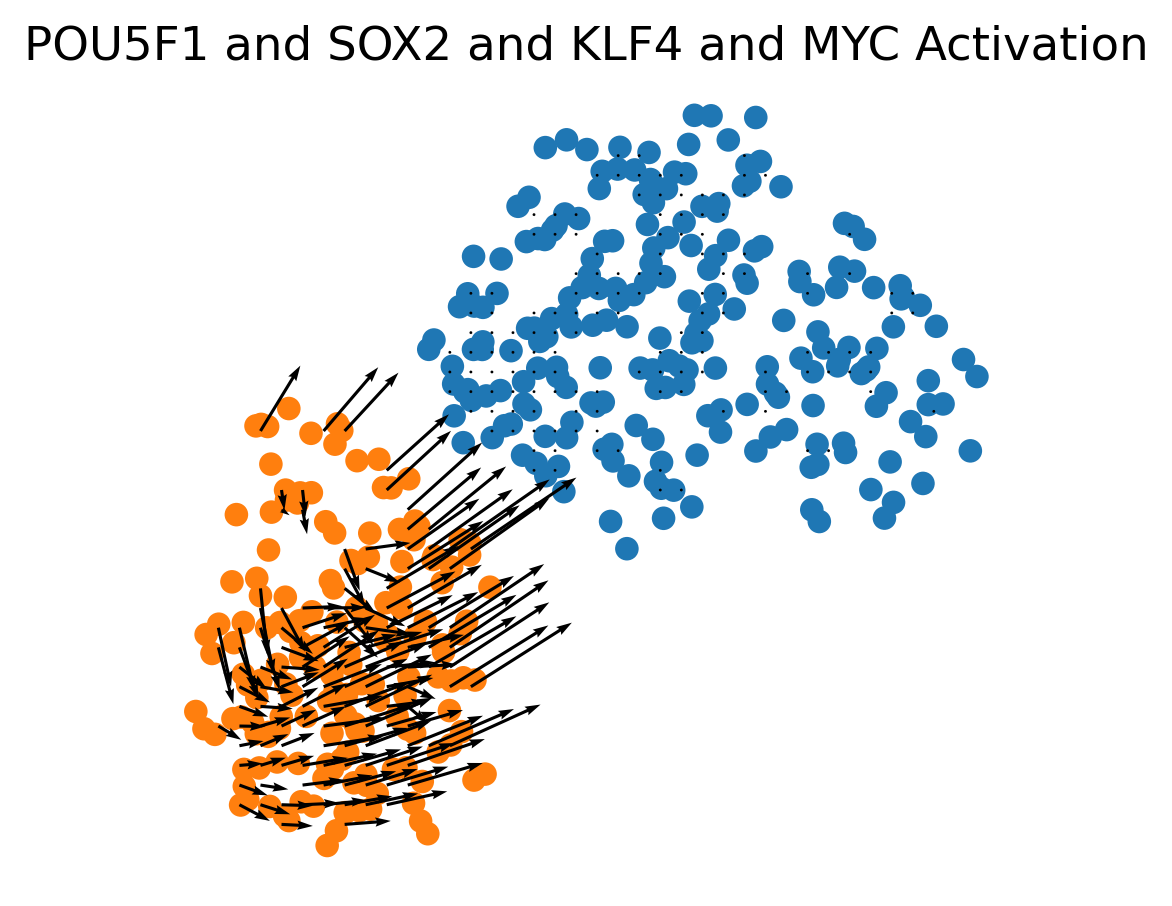

In [186]:
pert_plot_up(adata_TF, adata_down, model, state_pair=('ESC', 'Fibroblast'), KO_Gene=['POU5F1','SOX2', 'KLF4', 'MYC'], state_obs=state_obs,run_suggest_mass_thresholds=False,fold=[40,40,40,40],dot_size=dot_size, method=None, scale=8, min_mass=2,save_dir=output_path,draw_single='Fibroblast',embedding_name='X_umap',n_neighbors=200)

## Draw regulon

In [9]:
def draw_regulon(regulator, RGMs, output_path):
    import networkx as nx
    from matplotlib.patches import FancyArrowPatch
    os.makedirs(output_path, exist_ok=True)
    df = RGMs[regulator]
    df = df.sort_values(by=2, ascending=True).drop_duplicates(subset=[0, 1], keep='first')
    G = nx.DiGraph()
    edge_colors = []
    for _, row in df.iterrows():
        G.add_edge(row[0], row[1], attribute=row[2])
        if row[2] == 'Activation':
            edge_colors.append('green')
        elif row[2] == 'Repression':
            edge_colors.append('red')
        else:
            edge_colors.append('grey')
    node_attributes = pd.Series(index=G.nodes(), dtype=str)
    for _, row in df.iterrows():
        node_attributes[row[0]] = row[2]
        node_attributes[row[1]] = row[2]
    groups = node_attributes.unique()
    grouped_nodes = {group: list(node_attributes[node_attributes == group].index) for group in groups}
    nodes_sorted = []
    for group in groups:
        nodes_sorted.extend(grouped_nodes[group])
    def circos_layout(nodes, radius):
        pos = dict()
        theta = np.linspace(0, 2 * np.pi, len(nodes), endpoint=False)
        for node, angle in zip(nodes, theta):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = (x, y)
        return pos
    pos = circos_layout(nodes_sorted, radius=1)
    plt.figure(figsize=(10, 8))
    plt.gca().set_facecolor('white')
    plt.grid(False)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    for (u, v), color in zip(G.edges(), edge_colors):
        start = np.array(pos[u])
        end = np.array(pos[v])
        dx, dy = end - start
        length = np.sqrt(dx ** 2 + dy ** 2)
        unit_dx, unit_dy = dx / length, dy / length
        node_radius = 0.1
        start_arrow = start + node_radius * np.array([unit_dx, unit_dy])
        arrow = FancyArrowPatch(start_arrow, end-node_radius * np.array([unit_dx, unit_dy]), mutation_scale=15, color=color,
                                arrowstyle='-|>', lw=2)
        plt.gca().add_patch(arrow)
    handles = [
        plt.Line2D([0], [0], color='green', lw=2, label='Activation'),
        plt.Line2D([0], [0], color='red', lw=2, label='Repression'),
        plt.Line2D([0], [0], color='grey', lw=2, label='Unknown')
    ]
    plt.legend(handles=handles, title='Edge Attributes', loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon1.pdf'), format='pdf')
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon1.png'), format='png')
    plt.gca().invert_xaxis()
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon2.pdf'), format='pdf')
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon2.png'), format='png')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon3.pdf'), format='pdf')
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon3.png'), format='png')
    plt.gca().invert_xaxis()
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon4.pdf'), format='pdf')
    plt.savefig(os.path.join(output_path, f'{regulator}_regulon4.png'), format='png')

In [222]:
RGMs = {}
for i in adata.var_names[adata.var_names.isin(Trrust_TF)]:
    df = Trrust[Trrust[0] == i].iloc[:, 0:3]
    RGMs[i] = df[df[1].isin(adata.var_names[adata.var_names.isin(Trrust_nonTF)])]

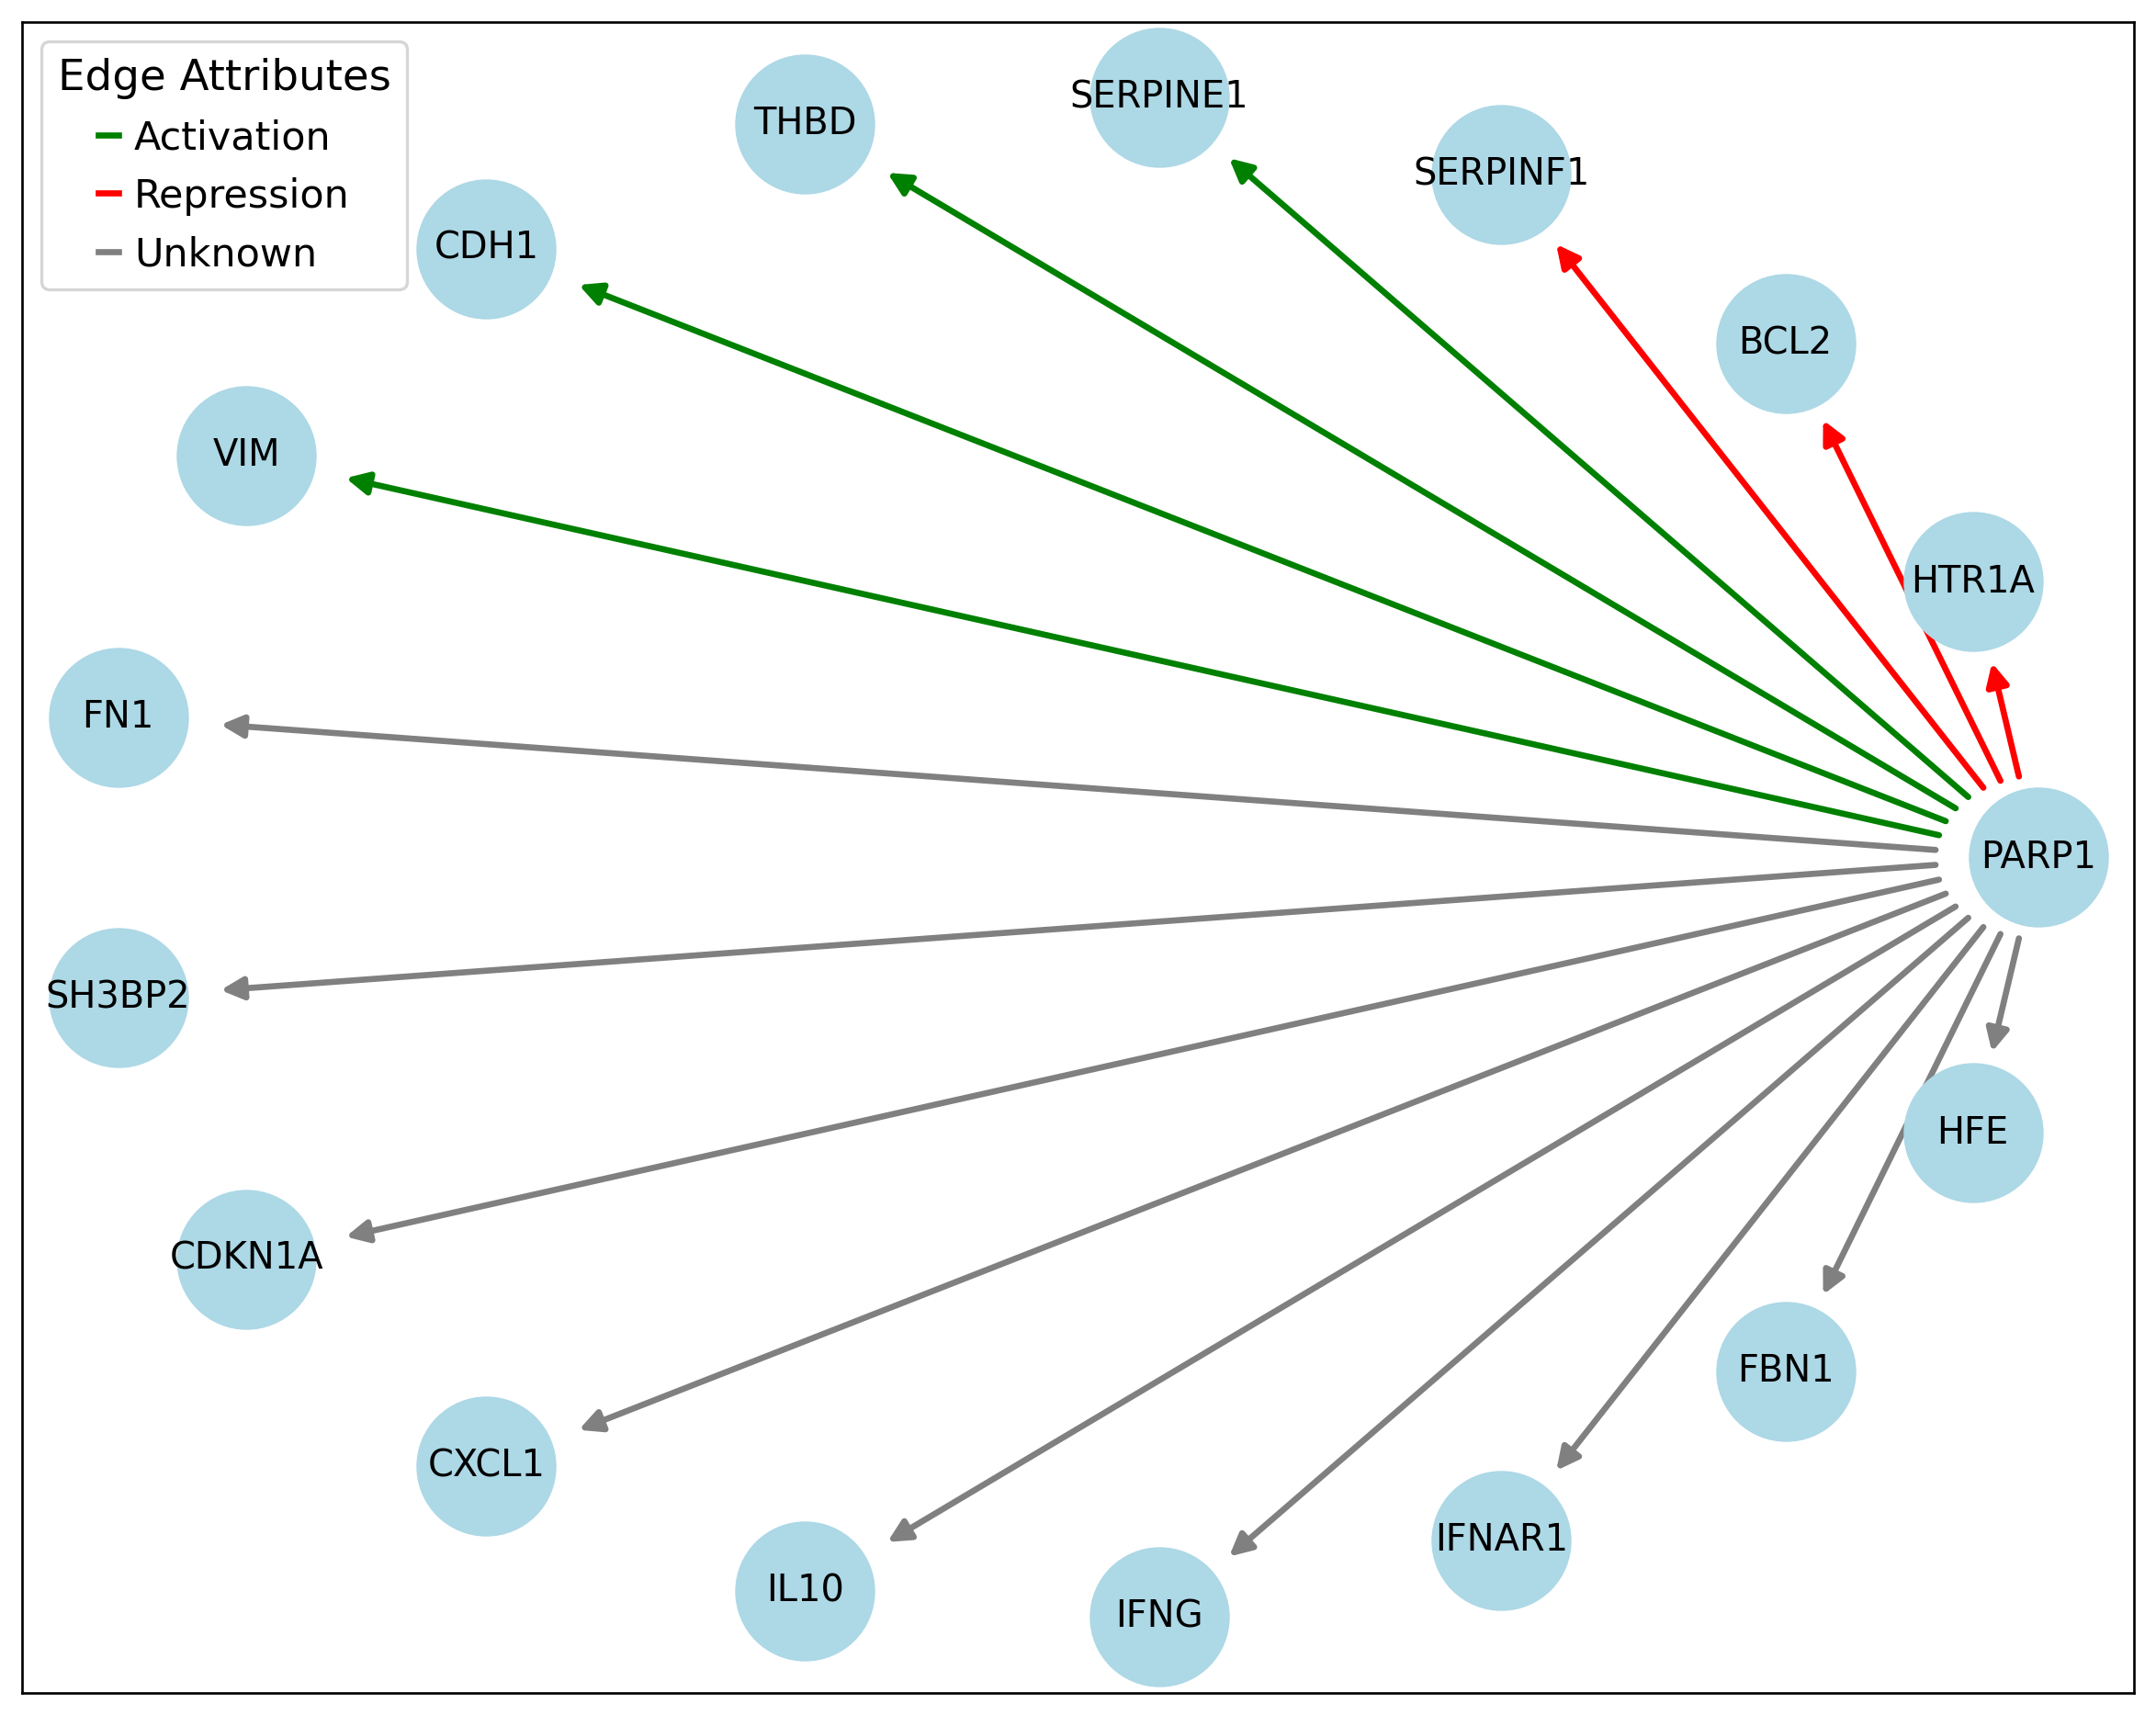

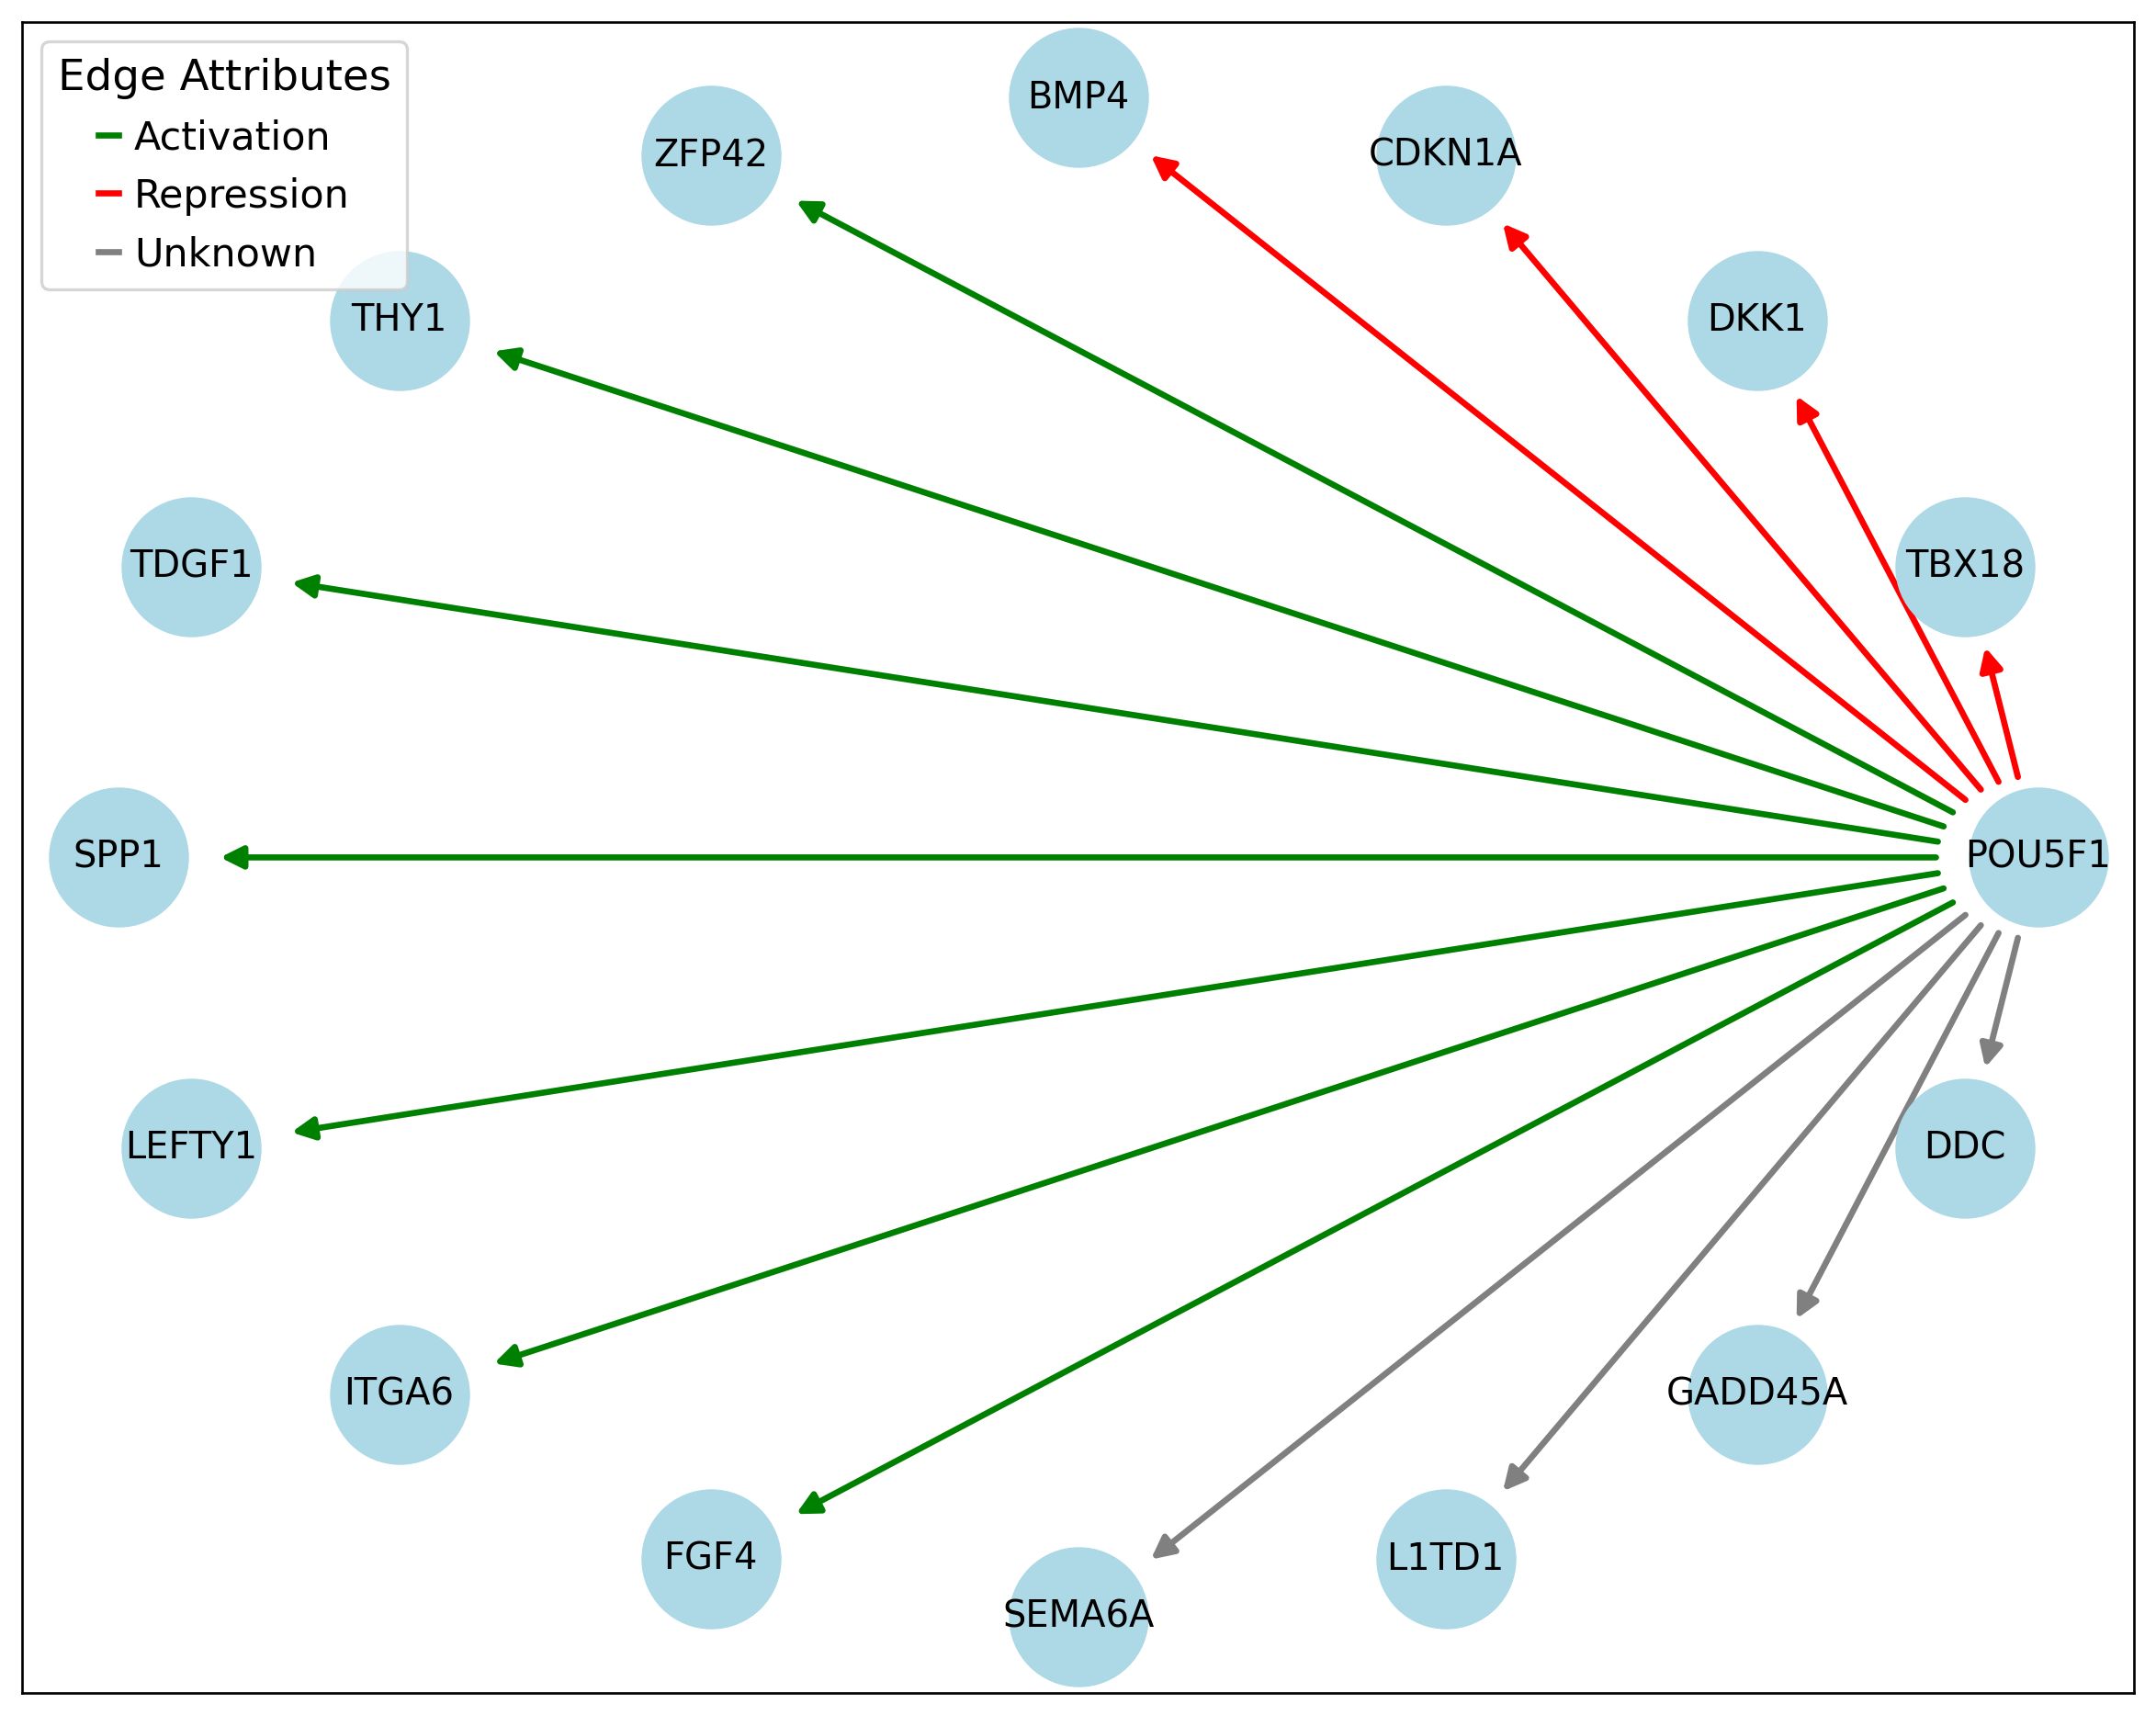

In [18]:
regulators = ['PARP1', 'POU5F1']
for regulator in regulators:
    draw_regulon(regulator, RGMs, output_path=os.path.join(output_path, f'regulons'))

## Comparison of change of targets and nontargets

training: 0it [00:00, ?it/s]


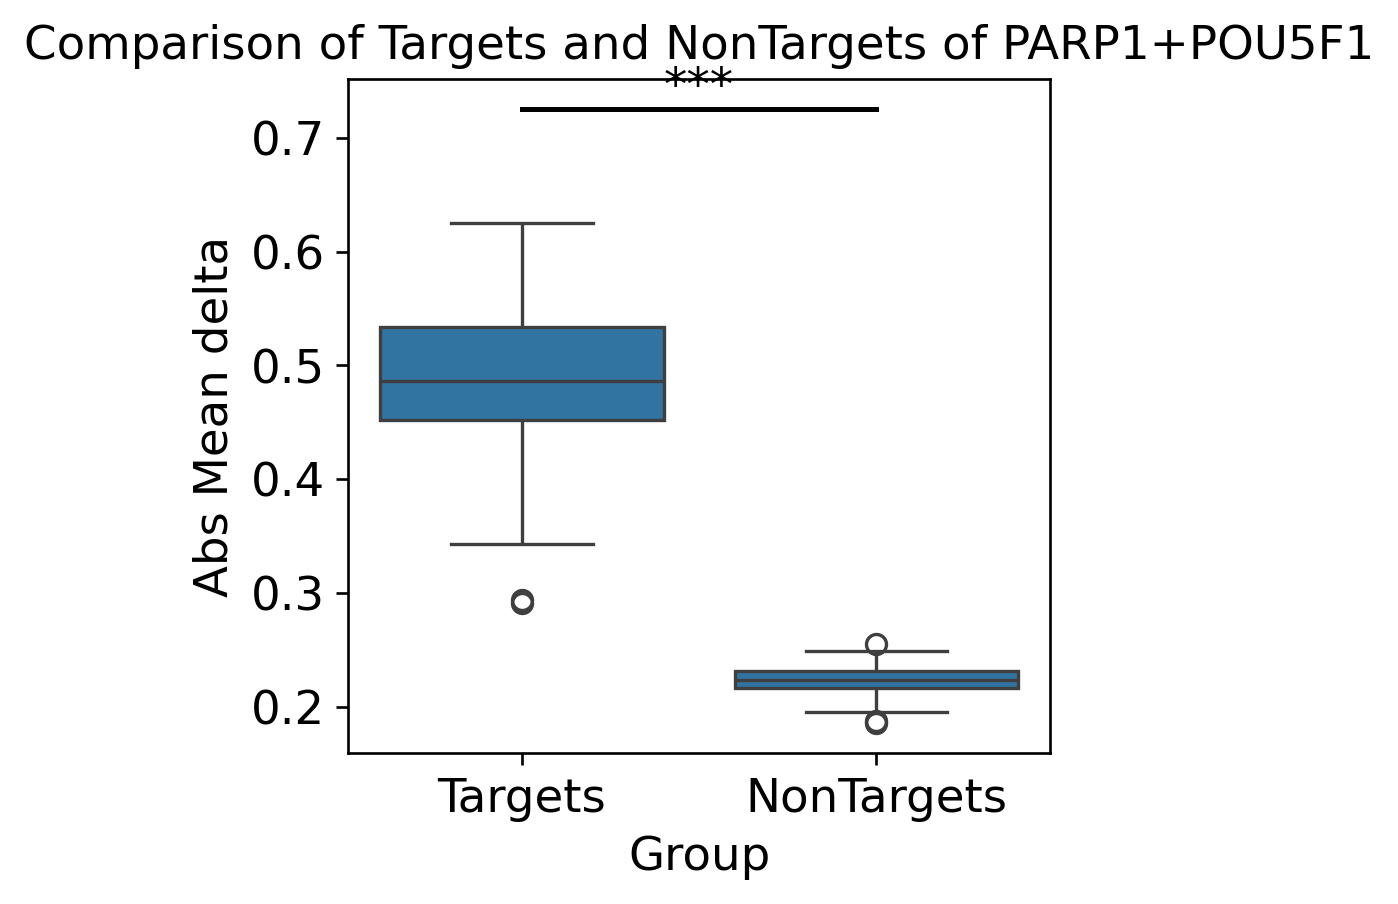

In [229]:
adata_TF = adata[:, adata.var_names.isin(Trrust_TF)].copy()
adata_down = adata[:, adata.var_names.isin(Trrust_nonTF)].copy()
state_pair = ('ESC', 'Fibroblast')
combo = ['PARP1', 'POU5F1']
pertA = combo[0]
pertB = combo[1]
fold = [40, 40]
adata_pertA = adata_TF.copy()
adata_pertB = adata_TF.copy()
adata_pertAB = adata_TF.copy()
pert_cell_idx = np.where(adata_TF.obs[state_obs] == state_pair[1])[0]
adata_pertA = adata_pertA[pert_cell_idx, :]
adata_pertB = adata_pertB[pert_cell_idx, :]
adata_pertAB = adata_pertAB[pert_cell_idx, :]
adata_ctrl = adata_down.copy()
adata_ctrl = adata_ctrl[np.where(adata_down.obs[state_obs] == state_pair[0])[0], :]
adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)] = fold[0] * adata_pertA.X[:, adata_pertA.var_names.get_loc(pertA)].max()
adata_pertB.X[:, adata_pertB.var_names.get_loc(pertB)] = fold[1] * adata_pertB.X[:, adata_pertB.var_names.get_loc(pertB)].max()
adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertA)] = fold[0] * adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertA)].max()
adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertB)] = fold[1] * adata_pertAB.X[:, adata_pertAB.var_names.get_loc(pertB)].max()
model.eval()
with torch.no_grad():
    model_output_pertA = model.get_model_output(adata_pertA)
    model_output_pertB = model.get_model_output(adata_pertB)
    model_output_pertAB = model.get_model_output(adata_pertAB)

targetsA = np.unique(RGMs[pertA][1])
targetsB = np.unique(RGMs[pertB][1])
targetsAB = np.unique(np.concatenate([targetsA, targetsB]))
nontargetsAB = np.setdiff1d(adata_down.var_names, targetsAB)
targetsA_delta = model_output_pertAB['x_down_rec_alpha'][:,np.isin(adata_down.var_names, targetsAB)] - adata_down[np.where(adata_down.obs[state_obs] == state_pair[1])[0],np.isin(adata_down.var_names, targetsAB)].X
nontargetsA_delta = model_output_pertAB['x_down_rec_alpha'][:,np.isin(adata_down.var_names, nontargetsAB)] - adata_down[np.where(adata_down.obs[state_obs] == state_pair[1])[0],np.isin(adata_down.var_names, nontargetsAB)].X
targetsA_mean = abs(np.mean(targetsA_delta, axis=1))
nontargetsA_mean = abs(np.mean(nontargetsA_delta, axis=1))
df = pd.DataFrame({
    'Values': np.concatenate([targetsA_mean, nontargetsA_mean]),
    'Group': ['Targets'] * len(targetsA_mean) + ['NonTargets'] * len(nontargetsA_mean)
})
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(targetsA_mean, nontargetsA_mean)
plt.figure(figsize=(4,4))
ax = sns.boxplot(x='Group', y='Values', data=df)
plt.ylabel("Abs Mean delta")
plt.title(f"Comparison of Targets and NonTargets of {pertA}+{pertB}")
if p_value < 0.05:
    significance = '*'
    if p_value < 0.01:
        significance = '**'
        if p_value < 0.001:
            significance = '***'
    x1, x2 = 0, 1
    y, h = df['Values'].max() + 0.1, 0
    ax.plot([x1, x2], [y, y], color='black')
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom')
plt.grid(False, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_path, f'Comparison of Targets and NonTargets of {pertA}+{pertB}.pdf'))
plt.show()